In [1]:
from kiara import Kiara
from kiara.utils.jupyter import graph_to_image

# Network analysis modules and workflow (backend)

This notebook outlines the first sketch of the Kiara backend-side modules (I expect frontend modules to not map directly
 to most backend ones, and overall be less fine-grained) and pipelines involved in creating a network
analysis workflow, as well as a quick introduction into how Kiara can be used programmatically.

The latter is still a bit wonky, and later on I'll provide wrapping classes and functions to make that programmatic
access feel more natural and pytonic, but for now this is not a priority.

## The ``Kiara`` object

When using the Python API of *Kiara*, the first thing to do is to create a [``Kiara``](https://dharpa.org/kiara/development/kiara_control_object/) object:

In [2]:
kiara = Kiara.instance()

This object is the central control object we need to create, manage and run workflows and data. It also helps us investigate
the current states and properties of the main entities we manage:

- **[``module``](https://dharpa.org/kiara/modules/)**: a module is the main building block in *Kiara*, at its core it's a Python class that specifies a set of inputs and outputs along with schema information, and a function that processes inputs and turns them into outputs.
- **[``pipeline``](https://dharpa.org/kiara/modules/pipeline_modules/)**: a pipeline is a special form of *module*, it contains one or several other modules (which can also be pipelines), internally connects them in a graph-structure (inputs of some modules to outputs of others). Pipelines also have a set of inputs and outputs themselves, the pipeline processing function is what turns inputs into outputs here.
- **[``workflow``](https://dharpa.org/kiara/workflows/)**: a workflow is basically an instantiated, top-level pipeline, wrapped in a way to make it easy to interact with. A workflow has a state, unlike *modules*, for example it holds current values for inputs/outputs and a list of currently processing child modules (it will at some stage, anyway).

Let's start our tour of *Kiara* with investigating which modules are available to us:

In [3]:
kiara.explain(kiara.modules_list)

 add_nodes_to_network_graph      Add nodes to an existing graph.                            
                                                                                             
  and                             Returns 'True' if both inputs are 'True'.                  
                                                                                             
  augment_network_graph           Augment an existing graph with node attributes.            
                                                                                             
  create_graph_from_edges_table   Create a directed network graph object from tabular data.  
                                                                                             
  create_network_graph            Create a network graph from 2 tabular data sets: one that  
                                  contains the edges, one that contains node attributes      
                                                                                             
  create_table                    Import table-like data from an item in the data registry.  
                                                                                             
  dummy                           Module that simulates processing, but uses hard-coded      
                                  outputs as a result.                                       
                                                                                             
  find_shortest_path              Find the shortest path between two nodes in a graph.       
                                                                                             
  graph_properties                Extract inherent properties of a network graph.            
                                                                                             
  import_local_file               Read a file into the data registry.                        
                                                                                             
  import_local_folder             -- n/a --                                                  
                                                                                             
  nand                            Returns 'False' if both inputs are 'True'.                 
                                                                                             
  network_analysis                First iteration of a network analysis pipeline. This       
                                  doesn't do much yet.                                       
                                                                                             
  nor                             Returns 'True' if both inputs are 'False'.                 
                                                                                             
  not                             Negates the input.                                         
                                                                                             
  or                              Returns 'True' if one of the inputs is 'True'.             
                                                                                             
  prepare_nodes_table_lena        Prepare tabular data so it can be used as a 'nodes_table'  
                                  input in the a directed graph module.                      
                                                                                             
                                  This is a very specific module, only accepting a very      
                                  specific data format and as such only suitable as a        
                                  proof-of-concept.                                          
                                  Later on, this will be replaced by a more generic module   
                                  (or pipeline).     

This line shows us two important attributes of the ``kiara`` object:

- ``explain``: this function can be used on/with most of the entities we are going to work with. If you want to know what
something is, feed it to ``kiara.explain(...)``. If the information you get is unclear, or not what you'd expect, please
let me know, and I'll adjust the output (or add renderers for types that are not supported yet).
- ``module_list``: this object contains a list of all the available modules, and their details (to only get the names of available
modules, call ``kiara.available_module_types`` )

## Creating a network graph object from edges and (optional) nodes

Since in this instance we want to do network analysis, we'll somehow need to create a Python object representing a network
graph. I've written a preliminary module that shows how that will work in *Kiara*. Be aware that this is not exactly how
things will work in the future, because some important pieces of code that deal with data management are not implemented
yet. But I hope this here will get the rough concept across.

So, the module to create a network graph (currently from two csv files) is called, aptly ``create_network_graph``. Let's ask *Kiara* about it:

In [4]:
module_info = kiara.get_module_info("create_network_graph")
kiara.explain(module_info)

PipelineModule: create_network_graph
                                                                                             
  class               kiara.modules.pipelines.CreateNetworkGraph                             
                                                                                             
  is pipeline         yes                                                                    
                                                                                             
  doc                 Create a network graph from 2 tabular data sets: one that contains     
                      the edges, one that contains node attributes                           
                                                                                             
  config class        kiara.config.PipelineModuleConfig                                      
                                                                                             
  config               ───────────────────────────────────────────────────────               
                        constants   object   Value constants for this module.                
                        meta        object   Metadata for this workflow.                     
                       ───────────────────────────────────────────────────────               
                                                                                             
  pipeline inputs     edges_path:                                                            
                        type: string                                                         
                        doc: The path to the file.                                           
                      nodes_path:                                                            
                        type: string                                                         
                        doc: The path to the file.                                           
                      source_column:                                                         
                        type: string                                                         
                        doc: The name of the column that contains the edge source in edges…  
                      target_column:                                                         
                        type: string                                                         
                        doc: The name of the column that contains the edge target in the e…  
                      weight_column:                                                         
                        type: string                                                         
                        doc: The name of the column that contains the edge weight in edges…  
                      graph_type:                                                            
                        type: string                                                         
                        doc: "The type of the graph. Allowed: 'undirected', 'directed', 'm…  
                          \ 'multi_undirected'."                                             
                      nodes_table_index:                                                     
                        type: string                                                         
                        doc: The name of the column that contains the node index in the no…  
                          table.                                                             
                                                                                             
  pipeline outputs    graph:                                                                 
                        type: network_graph                                                  
                        doc: The network graph                                               
               

This information is mostly relevant for workflow creators, because it shows low-level information about the module type and its properties. For example, here we can see that this module is composed of other modules, and therefore a 'pipeline'. More interesting, and also a bit more intuitive is looking at the pipeline structure:

In [5]:
# now we know that the module is a pipeline, we can request the pipeline-specific info object
kiara.explain(module_info.structure)

Pipeline structure: create_network_graph

Inputs / Outputs
                                                                                             
  ╭─ Input fields ────────────────────────────────────────────────────────────────────────╮  
  │                                                                                       │  
  │   Name                Type     Description              Required       Default        │  
  │  ───────────────────────────────────────────────────────────────────────────────────  │  
  │   edges_path          string   The path to the file.      yes      -- no default --   │  
  │                                                                                       │  
  │   nodes_path          string   The path to the file.       no      -- no default --   │  
  │                                                                                       │  
  │   source_column       string   The name of the column      no           source        │  
  │                                that contains the edge                                 │  
  │                                source in edges table.                                 │  
  │                                                                                       │  
  │   target_column       string   The name of the column      no           target        │  
  │                                that contains the edge                                 │  
  │                                target in the edges                                    │  
  │                                table.                                                 │  
  │                                                                                       │  
  │   weight_column       string   The name of the column      no           weight        │  
  │                                that contains the edge                                 │  
  │                                weight in edges table.                                 │  
  │                                                                                       │  
  │   graph_type          string   The type of the graph.      no          directed       │  
  │                                Allowed: 'undirected',                                 │  
  │                                'directed',                                            │  
  │                                'multi_directed',                                      │  
  │                                'multi_undirected'.                                    │  
  │                                                                                       │  
  │   nodes_table_index   string   The name of the column      no      -- no default --   │  
  │                                that contains the node                                 │  
  │                                index in the node                                      │  
  │                                attributes table.                                      │  
  │                                                                                       │  
  ╰───────────────────────────────────────────────────────────────────────────────────────╯  
  ╭─ Output fields ───────────────────────────────────────────────────────────────────────╮  
  │                                                                                       │  
  │   Name    Type            Description                                                 │  
  │  ───────────────────────────────────────────                                          │  
  │   graph   network_graph   The network graph                                           │  
  │                                                                                       │  
  ╰───────────────────────────────────────────────────────────────────────────────────────╯  
                                                                                       

This is way more useful, it shows us which inputs the pipeline expects, what their meaning and type is, among other things.
It also shows us which modules the pipeline uses internally, and how their inputs and outputs are wired together.
Basically, every module that is included in a pipeline represents an execution step, and is assigned a unique step id
which is used to connect to it's inputs/outputs. *kiara* computes the execution order of the pipeline, depending on
the dependencies of each step.

If we want a more graphical representation of the pipeline structure, we can do that too:

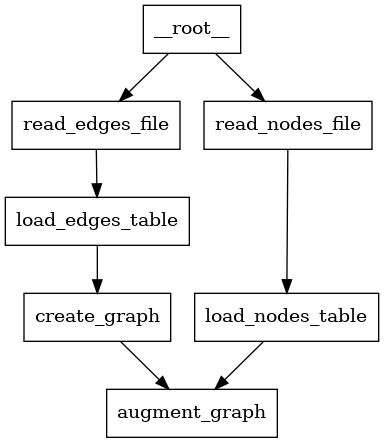

In [6]:
graph_to_image(module_info.structure.execution_graph)
# also try out the full blown data flow graph:
# graph_to_image(module_info.structure.data_flow_graph)

We can use this information to get more detailed information about one of it's child modules, for example, let's find
out more about the ``create_graph_from_edges_table`` module:

In [7]:
module_info = kiara.get_module_info('create_graph_from_edges_table')
kiara.explain(module_info)

╭─ Module: create_graph_from_edges_table ───────────────────────────────────────────────────╮
│                                                                                           │
│   class          kiara_modules.default.network_analysis.CreateGraphFromEdgesTableModule   │
│                                                                                           │
│   is pipeline    no                                                                       │
│                                                                                           │
│   doc            Create a directed network graph object from tabular data.                │
│                                                                                           │
│   source repo    ]8;id=1620380146.7767038-445484;https://dharpa.org/kiara_modules.default/api_reference/kiara_modules.default.network_analysis/#kiara_modules.default.network_analysis.CreateGraphFromEdgesTableModule\kiara_modules.default.create_graph_from_edges_table]8;;\                      │
│                                                                                           │
│   config class   kiara_modules.default.network_analysis.CreateGraphConfig                 │
│                                                                                           │
│   config          ────────────────────────────────────────────────────────────────────    │
│                    constants    object   Value constants for this module.                 │
│                    graph_type   string   The type of the graph. If not specified, a       │
│                                          'graph_type' input field will be added which     │
│                                          will default to 'directed'.                      │
│                   ────────────────────────────────────────────────────────────────────    │
│                                                                                           │
│   src            def process(self, inputs: StepInputs, outputs: StepOutputs) -> None:     │
│                                                                                           │
│                      if self.get_config_value("graph_type") is not None:                  │
│                          _graph_type = self.get_config_value("graph_type")                │
│                      else:                                                                │
│                          _graph_type = inputs.graph_type                                  │
│                                                                                           │
│                      graph_type = GraphTypesEnum[_graph_type]                             │
│                                                                                           │
│                      edges_table_value = inputs.get_value_obj("edges_table")              │
│                      edges_table_obj: pyarrow.Table = edges_table_value.get_value_data…   │
│                                                                                           │
│                      source_column = inputs.source_column                                 │
│                      target_column = inputs.target_column                                 │
│                      weight_column = inputs.weight_column                                 │
│                                                                                           │
│                      errors = []                                                          │
│                      if source_column not in edges_table_obj.column_names:                │
│                          errors.append(source_column)                                     │
│                      if target_column not in edges_table_obj.column_names:                │
│                          errors.append(target_column)                                     │
│                      if weight_

Again, this is low level information, and unless we are workflow creators we are probably not interested in this. But
I wanted to show how the details of a non-pipeline module look. Esp. interesting is the 'src' attribute, which contains
the code that is responsible to transform inputs to outputs, and making it accessible is one requirement
of our project.


## Create the workflow

Now that we have established that we want to use the ``create_network_graph`` module to load our graph data and create
a network object, lets create a workflow from it:

In [8]:
create_workflow = kiara.create_workflow("create_network_graph")

*Kiara* has a nice little method that explains the processing steps that a workflow contains in a more human readable
way than what we have seen above:

In [9]:
kiara.explain(create_workflow.steps)

╭─ Stages for pipeline: create_network_graph_0 ─────────────────────────────────────────────╮
│                                                                                           │
│  Processing stage 1:                                                                      │
│                                                                                           │
│    - read_edges_file: Read a file into the data registry.                                 │
│                                                                                           │
│    - read_nodes_file (optional): Read a file into the data registry.                      │
│                                                                                           │
│  Processing stage 2:                                                                      │
│                                                                                           │
│    - load_edges_table: Import table-like data from an item in the data registry.          │
│                                                                                           │
│    - load_nodes_table (optional): Import table-like data from an item in the data         │
│  registry.                                                                                │
│                                                                                           │
│  Processing stage 3:                                                                      │
│                                                                                           │
│    - create_graph: Create a directed network graph object from tabular data.              │
│                                                                                           │
│  Processing stage 4:                                                                      │
│                                                                                           │
│    - augment_graph: Augment an existing graph with node attributes.                       │
│                                                                                           │
╰───────────────────────────────────────────────────────────────────────────────────────────╯

Steps that are in the same processing stage can be executed in parallel. The nice thing about this is that the user and
not even the workflow creator needs to worry about this (or have any knowledge about parallel processing), *Kiara* will
just do the right thing (not implemented yet though).

### Workflow inputs

For a workflow to be useful, we need input data we want to transform into output data. Kiara can tell us what we need:

In [10]:
kiara.explain(create_workflow.inputs)

╭─ Value-Set: Inputs for pipeline 'create_network_graph_0' ─────────────────────────────────╮
│                                                                                           │
│   Field name          Type     Description                            Required   Is set   │
│  ───────────────────────────────────────────────────────────────────────────────────────  │
│   edges_path          string   The path to the file.                  yes        no       │
│   nodes_path          string   The path to the file.                  no         yes      │
│   source_column       string   The name of the column that contains   no         yes      │
│                                the edge source in edges table.                            │
│   target_column       string   The name of the column that contains   no         yes      │
│                                the edge target in the edges table.                        │
│   weight_column       string   The name of the column that contains   no         yes      │
│                                the edge weight in edges table.                            │
│   graph_type          string   The type of the graph. Allowed:        no         yes      │
│                                'undirected', 'directed',                                  │
│                                'multi_directed',                                          │
│                                'multi_undirected'.                                        │
│   nodes_table_index   string   The name of the column that contains   no         yes      │
│                                the node index in the node                                 │
│                                attributes table.                                          │
│                                                                                           │
╰───────────────────────────────────────────────────────────────────────────────────────────╯

In this case, it looks like the ``edges_path`` is the only required input. As you can see from the table, some values
already appear to be ``set``, even though we didn't do anything. This is because those values have defaults (as you can see from the
output of the 'structure' details above).

Ok, let's get to it, and set that required inputs (input files are in the same folder here):

In [11]:
create_workflow.inputs.edges_path = "simple_graph_1_edges.csv"

Processing of step 'create_graph' from pipeline 'create_network_graph_0' failed: Can't create network graph, source table missing column(s): source, target, weight. Available columns: Source, Target, Weight.


...and check whether anything changed:

In [12]:
kiara.explain(create_workflow.inputs)

╭─ Value-Set: Inputs for pipeline 'create_network_graph_0' ─────────────────────────────────╮
│                                                                                           │
│   Field name          Type     Description                            Required   Is set   │
│  ───────────────────────────────────────────────────────────────────────────────────────  │
│   edges_path          string   The path to the file.                  yes        yes      │
│   nodes_path          string   The path to the file.                  no         yes      │
│   source_column       string   The name of the column that contains   no         yes      │
│                                the edge source in edges table.                            │
│   target_column       string   The name of the column that contains   no         yes      │
│                                the edge target in the edges table.                        │
│   weight_column       string   The name of the column that contains   no         yes      │
│                                the edge weight in edges table.                            │
│   graph_type          string   The type of the graph. Allowed:        no         yes      │
│                                'undirected', 'directed',                                  │
│                                'multi_directed',                                          │
│                                'multi_undirected'.                                        │
│   nodes_table_index   string   The name of the column that contains   no         yes      │
│                                the node index in the node                                 │
│                                attributes table.                                          │
│                                                                                           │
╰───────────────────────────────────────────────────────────────────────────────────────────╯

Apparently it did. So it looks like all required inputs are set now, which means we should be able to actually have some results.

*Note*: in this example, *kiara* automatically starts processing whenever an input is set. This is configurable, and not
always the case.

To check our outputs, we do:

In [13]:
kiara.explain(create_workflow.outputs)

╭─ Value-Set: Outputs for pipeline 'create_network_graph_0' ────────────────────────────────╮
│                                                                                           │
│   Field name   Type            Description         Required   Is set                      │
│  ────────────────────────────────────────────────────────────────────                     │
│   graph        network_graph   The network graph   yes        no                          │
│                                                                                           │
╰───────────────────────────────────────────────────────────────────────────────────────────╯

Hu? Output not set?

It looks like something went wrong. It did, details about how to debug this sort of thing will be added later, for now
I just tell you what the issue is: our edges table did have different column names than the defaults of our module (all lowercase defaults,
but our table has capitalized column names). So, let's set those too, and check our outputs:

In [14]:
create_workflow.inputs.source_column = "Source"
create_workflow.inputs.target_column = "Target"
create_workflow.inputs.weight_column = "Weight"

kiara.explain(create_workflow.outputs)


Processing of step 'create_graph' from pipeline 'create_network_graph_0' failed: Can't create network graph, source table missing column(s): target, weight. Available columns: Source, Target, Weight.
Processing of step 'create_graph' from pipeline 'create_network_graph_0' failed: Can't create network graph, source table missing column(s): weight. Available columns: Source, Target, Weight.


╭─ Value-Set: Outputs for pipeline 'create_network_graph_0' ────────────────────────────────╮
│                                                                                           │
│   Field name   Type            Description         Required   Is set                      │
│  ────────────────────────────────────────────────────────────────────                     │
│   graph        network_graph   The network graph   yes        yes                         │
│                                                                                           │
╰───────────────────────────────────────────────────────────────────────────────────────────╯

Yay, seems to have worked! Let's look at details of our result data:

In [15]:
kiara.explain(create_workflow.outputs.graph)

╭─ Value: step_output:create_network_graph_0.augment_graph.graph ───────────────────────────╮
│                                                                                           │
│   id            2e928211-5fe2-4161-8140-a4b01e0e434d                                      │
│   type          network_graph                                                             │
│   desc          The network graph                                                         │
│   is set        yes                                                                       │
│   is constant   no                                                                        │
│   metadata      {                                                                         │
│                   "type": {                                                               │
│                     "python_cls": "networkx.classes.digraph.DiGraph",                     │
│                     "directed": true,                                                     │
│                     "number_of_nodes": 3,                                                 │
│                     "number_of_edges": 3,                                                 │
│                     "density": 0.5                                                        │
│                   }                                                                       │
│                 }                                                                         │
│                                                                                           │
╰───────────────────────────────────────────────────────────────────────────────────────────╯

This tells us the internal dataset id, it's type, and some other metadata. More metadata wil be added later (like lineage information, etc.), but this should give an idea of how this works.
And to get the actual result of the ``graph`` field (a networkx graph object), we can do the following:

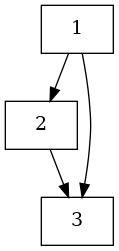

In [16]:
graph_obj = create_workflow.outputs.graph.get_value_data()
# this is just a networkx graph object
print(graph_obj)
# we can visualize it too:
graph_to_image(graph_obj)

If you remember the workflow inputs from above, there was also a field called 'nodes_path', which takes tabular data
that contains attributes for the node of our graph (and extra nodes that are not part of any edges, potentially).

We can set this too, and see if we get any other output (which we should, the table contains one extra node):

Processing of step 'augment_graph' from pipeline 'create_network_graph_0' failed: Node attribute table does not have a column with (index) name 'None'. Available column names: id, attr_1, attr_2


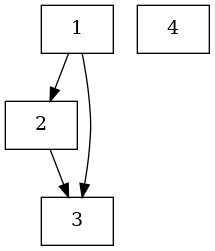

In [17]:
create_workflow.inputs.nodes_path = "simple_graph_1_nodes.csv"
create_workflow.inputs.nodes_table_index = "id"
graph_obj = create_workflow.outputs.graph.get_value_data()
graph_to_image(graph_obj)


## Workflow state

To wrap up that first part of how to create and work with workflows in *Kiara*, let's have a look at the state of the workflow
we created. I mentioned earlier that having state is the main difference between a workflow and a mere module. Looking
at that state might help understanding some of the underlying concepts and workings:

In [18]:
kiara.explain(create_workflow.current_state)

Pipeline state for: create_network_graph_0

Status: RESULTS_READY

Inputs / Outputs
                                                                                             
  ╭─ Inputs ──────────────────────────────────────────────────────────────────────────────╮  
  │                                                                                       │  
  │   Field name          Type     Description             Required    Status     Ready   │  
  │  ───────────────────────────────────────────────────────────────────────────────────  │  
  │   edges_path          string   The path to the file.   yes        -- set --    yes    │  
  │   nodes_path          string   The path to the file.   no         -- set --    yes    │  
  │   source_column       string   The name of the         no         -- set --    yes    │  
  │                                column that contains                                   │  
  │                                the edge source in                                     │  
  │                                edges table.                                           │  
  │   target_column       string   The name of the         no         -- set --    yes    │  
  │                                column that contains                                   │  
  │                                the edge target in                                     │  
  │                                the edges table.                                       │  
  │   weight_column       string   The name of the         no         -- set --    yes    │  
  │                                column that contains                                   │  
  │                                the edge weight in                                     │  
  │                                edges table.                                           │  
  │   graph_type          string   The type of the         no         -- set --    yes    │  
  │                                graph. Allowed:                                        │  
  │                                'undirected',                                          │  
  │                                'directed',                                            │  
  │                                'multi_directed',                                      │  
  │                                'multi_undirected'.                                    │  
  │   nodes_table_index   string   The name of the         no         -- set --    yes    │  
  │                                column that contains                                   │  
  │                                the node index in the                                  │  
  │                                node attributes                                        │  
  │                                table.                                                 │  
  │                                                                                       │  
  ╰───────────────────────────────────────────────────────────────────────────────────────╯  
  ╭─ Outputs ─────────────────────────────────────────────────────────────────────────────╮  
  │                                                                                       │  
  │   Field name   Type            Description         Required    Status     Ready       │  
  │  ───────────────────────────────────────────────────────────────────────────────      │  
  │   graph        network_graph   The network graph   yes        -- set --    yes        │  
  │                                                                                       │  
  ╰───────────────────────────────────────────────────────────────────────────────────────╯  
                                                                                             
Steps
                                                                                             
  ╭─ Processing stage: 1 ───────────────────────────────

As you can see, the state consists of the current 'status' (``RESULTS_READY`` in our case), the state of each input
and output of the workflow, as well as the state of each individual step of the workflow.

Play around a bit with workflows, and don't set some of the required inputs, then check the workflow state. You'll see that
some (or all) internal steps show a ``STALE`` status, among other things that will be different.

## Thoughts about 'data onboarding'

The first part of this notebook described what I think of as a 'data onboarding' process: getting 'outside' data into
a format we can work with, internally. The qualitative characteristic of the data itself didn't change, only it's byte representation.

In this context, it helps stop thinking of data in terms of 'files', because that's counter-productive. A bit like the
thing we talked about on slack, that a map is not the territory. A file is not the data, it's just a medium that can help
transport and store it, but it's just one potential way among many. The same table can be stored as csv, Excel file, json, etc.
And it doesn't even have to be a file, a network protocol can also transport the same data.
We are used to equate a file with the data, because in a lot of (non-science) cases, that just works. We have one Excel
file, and always only use Excel to open and edit it. So for all practical purposes the file is the data. Only once we want
to open that file with LibreOffice, or Google Docs, do we realize that there is a slight friction. And even then we might not
notice, because those applications usually spend a lot of effort to make this friction transparent to the user.

Unfortunately (or fortunately, depending on how you look at it), in e-sciencee, the data we deal with must be opened by different applications, which
is why usually some sort of standard is agreed upon. Csv, json, Arrow, etc. But even if there is some standard everyone follows
(which is far from guaranteed), files following those standards are not the 'data'. Because the applications
we use to read those (standard-following) files then convert it into another (internal) format (maybe a Python dict).
In addition, whether different applications interpret the data in the same way is by no means a sure thing...

The discussion gets a bit metaphysical at this point, but luckily we don't need to actually follow this thought all the way through.
For our case, we just need to find a low enough level of abstraction where the data format we use is sufficiently generic so that we only
ever have to convert it 'up', and never 'down'. By that I mean: we must be able to export our internal data into all kinds
of other, commonly used formats (like csv, json). And we have to have a way to import those formats and convert it to our
internal one. But we can rely upon the fact there won't be a situation that two datasets (in our internal format) can't be used
by the same functions/API endpoints, and we can always use the same (domain-specific) language to describe the data and its metadata.
I'm sorry if this is a bit too abstract, and I'm pretty sure my way of describing the issue is sub-optimal, but in my
mind this is one of the central issues of the overall problem we are trying to solve, and understanding this is instrumental
to finding a good solution.

One aspect of all this is that I think we should use the 'file' metaphor in our documentation and UI as little as possible,
and instead make it clear that we are dealing with 'data' and 'datasets'. Except for the import/export functionality of course
(data onboarding and data export). But even then, we should think about how we can make it clear that 'data' is what is
important, not files.

Long story short: the sole purpose of the onboarding pipeline I described above is to convert csv files into a Python networkx
graph object. It should be clear that this does not need to be the only such pipeline. For example, we could imagine a pipeline
that, instead of reading csv files, executes a sql query against a database, and turns the result into the graph object.
That pipeline would probably re-use one or several of the modules our csv-import pipeline users (``augment_graph``, for example),
but it would have totally different inputs. But the output is the same (well, at least the output type).

Keeping all that in mind, it should be clear that we'll have a category of 'special' modules. Their sole (or at least 'main')
purpose is to convert whatever random byte-clumps are out there in Non-Kiara-land into 'Kiara-approved' pieces of data.
Within a pipeline, we can swap one of those modules with any other that yields the same result data type (``network_graph``,
in our case). This is important to understand. Because it allows us to really take full advantage of the modularity concept.
Our onboarding modules are the ones that are custom written for specific input types. The 'real' processing modules are
the ones that take data from one of a set of onboarding modules (except when the input is trivial), but don't need to worry
at all about how the data got into the format it is in (we will still save that information though). We can just assume
that they are of the right type, and we don't have to have code in those processing modules that deals with the different
potential input formats.

# Using the created graph object in the analysis module

Assuming we have a network object, we can start with the interesting part in all this: writing modules that help researchers
extract meaning from data (not just shuffling it around, and paint it in different colours as we did above).

As it turns out, the code to analyze network graphs is fairly trivial. Below, I'll describe the two modules I've written
so far, which follow mostly Lenas code: ``graph_properties`` and ``find_shortest_path``.

## Graph properties

For the first module, ``graph_properties``, I decided to collect all the functions that calculate properties of a graph
and which don't need any additional user input. There are a few reasons why I chose to encapsulate those in a single module,
I'll explain some of the advantages below.

Ok, let's get to it. First, let's look at the module and what it can do:

In [19]:
module_info = kiara.get_module_info('graph_properties')
kiara.explain(module_info)

╭─ Module: graph_properties ────────────────────────────────────────────────────────────────╮
│                                                                                           │
│   class          kiara_modules.default.network_analysis.ExtractGraphPropertiesModule      │
│                                                                                           │
│   is pipeline    no                                                                       │
│                                                                                           │
│   doc            Extract inherent properties of a network graph.                          │
│                                                                                           │
│   source repo    ]8;id=1620380147.4737968-906867;https://dharpa.org/kiara_modules.default/api_reference/kiara_modules.default.network_analysis/#kiara_modules.default.network_analysis.ExtractGraphPropertiesModule\kiara_modules.default.graph_properties]8;;\                                   │
│                                                                                           │
│   config class   kiara_modules.default.network_analysis.ExtractGraphPropertiesModuleCo…   │
│                                                                                           │
│   config          ────────────────────────────────────────────────────────────────────    │
│                    constants                object    Value constants for this            │
│                                                       module.                             │
│                    find_largest_component   boolean   Find the largest component of a     │
│                                                       graph.                              │
│                    number_of_nodes          boolean   Count the number of nodes.          │
│                    number_of_edges          boolean   Count the number of edges           │
│                    density                  boolean   Calculate the graph density.        │
│                   ────────────────────────────────────────────────────────────────────    │
│                                                                                           │
│   src            def process(self, inputs: StepInputs, outputs: StepOutputs) -> None:     │
│                                                                                           │
│                      graph: Graph = inputs.graph                                          │
│                                                                                           │
│                      if self.get_config_value("find_largest_component"):                  │
│                          lc_graph = copy.deepcopy(graph)                                  │
│                          # largest_component = max(nx.strongly_connected_components_re…   │
│                          lc_graph.remove_nodes_from(                                      │
│                              list(nx.isolates(lc_graph))                                  │
│                          )  # remove unconnected nodes from graph                         │
│                          lc_density = nx.density(lc_graph)                                │
│                          outputs.set_values(                                              │
│                              largest_component=lc_graph, density_largest_component=lc_…   │
│                          )                                                                │
│                                                                                           │
│                      if self.get_config_value("number_of_nodes"):                         │
│                          outputs.set_values(number_of_nodes=len(graph.nodes))             │
│                                                                                           │
│                      if self.get_c

One thing I haven't explained before is that modules can be configured. Supporting that was a practical decision, because
it helps in terms of code-reuse, and allows the same module to be (re-)used easier, in different circumstances.

If we look at the above info output for our ``graph_properties`` modules, we can see that it has a few switches that
allow us to turn on or off the calculation of certain properties.

To see what outputs the module produces without any configuration, we can create a workflow from it and print its
properties:

In [20]:
properties_workflow = kiara.create_workflow("graph_properties")
kiara.explain(properties_workflow)

Workflow: graph_properties_0
                                                                                             
  root module      pipeline                                                                  
  current status   STALE                                                                     
  inputs                                                                                     
                     Field name   Type            Description          Required   Is set     
                    ─────────────────────────────────────────────────────────────────────    
                     graph        network_graph   The network graph.   yes        no         
                                                                                             
  outputs                                                                                    
                     Field name        Type            Description      Required   Is set    
                    ──────────────────────────────────────────────────────────────────────   
                     largest_compon…   network_graph   A sub-graph of   yes        no        
                                                       the largest                           
                                                       component of                          
                                                       the graph.                            
                     density_larges…   float           The density of   yes        no        
                                                       the largest                           
                                                       component.                            
                     number_of_nodes   integer         The number of    yes        no        
                                                       nodes in the                          
                                                       graph.                                
                     number_of_edges   integer         The number of    yes        no        
                                                       edges in the                          
                                                       graph.                                
                     density           float           The density of   yes        no        
                                                       the graph.

As we can see, this module would produce a set of outputs. If we, say, would be only interested in the 'density' and 'largest_component' of
the graph, we can just 'switch off' all the other properties (in this particular case, that doesn't make much sense, but
if one of the switched off calculations would take a long time and we are not interested in it, it certainly would):

In [21]:
config = {
    "find_largest_component": True,
    "number_of_nodes": False,
    "number_of_edges": False,
    "density": True
}
properties_workflow = kiara.create_workflow("graph_properties", module_config=config)
kiara.explain(properties_workflow)

Workflow: graph_properties_1
                                                                                             
  root module      pipeline                                                                  
  current status   STALE                                                                     
  inputs                                                                                     
                     Field name   Type            Description          Required   Is set     
                    ─────────────────────────────────────────────────────────────────────    
                     graph        network_graph   The network graph.   yes        no         
                                                                                             
  outputs                                                                                    
                     Field name        Type            Description      Required   Is set    
                    ──────────────────────────────────────────────────────────────────────   
                     largest_compon…   network_graph   A sub-graph of   yes        no        
                                                       the largest                           
                                                       component of                          
                                                       the graph.                            
                     density_larges…   float           The density of   yes        no        
                                                       the largest                           
                                                       component.                            
                     density           float           The density of   yes        no        
                                                       the graph.

As we can see, our workflow only produces the 'density' and 'largest_component' result (along with the 'density' marker for the
largest component -- that's just how this particular module is implemented).

Now, for the purpose of this example we will re-use the result of our onboarding workflow directly in our 'analysis'
workflow(s). This is slightly different to how things would be done if the data management part of
*Kiara* was already implemented, but it shouldn't matter much in terms of trying to get the overall idea across.

Ok, let's set that input, and check the result(s):

In [22]:
properties_workflow.inputs.graph = create_workflow.outputs.graph

kiara.explain(properties_workflow.outputs)

╭─ Value-Set: Outputs for pipeline 'graph_properties_1' ────────────────────────────────────╮
│                                                                                           │
│   Field name                Type            Description               Required   Is set   │
│  ───────────────────────────────────────────────────────────────────────────────────────  │
│   largest_component         network_graph   A sub-graph of the        yes        yes      │
│                                             largest component of                          │
│                                             the graph.                                    │
│   density_largest_compon…   float           The density of the        yes        yes      │
│                                             largest component.                            │
│   density                   float           The density of the        yes        yes      │
│                                             graph.                                        │
│                                                                                           │
╰───────────────────────────────────────────────────────────────────────────────────────────╯

In [23]:
# get information about the actual output values (but not hte output data itself)
kiara.explain(properties_workflow.outputs.density)
kiara.explain(properties_workflow.outputs.largest_component)
kiara.explain(properties_workflow.outputs.density_largest_component)

╭─ Value: step_output:graph_properties_1.graph_properties.density ──────────────────────────╮
│                                                                                           │
│   id            b058f356-b1f6-4f2e-b810-0b1a69848d36                                      │
│   type          float                                                                     │
│   desc          The density of the graph.                                                 │
│   is set        yes                                                                       │
│   is constant   no                                                                        │
│   metadata      {                                                                         │
│                   "type": {                                                               │
│                     "python_cls": "float"                                                 │
│                   }                                                                       │
│                 }                                                                         │
│                                                                                           │
╰───────────────────────────────────────────────────────────────────────────────────────────╯

╭─ Value: step_output:graph_properties_1.graph_properties.largest_component ────────────────╮
│                                                                                           │
│   id            3d1edc3f-d5b2-4a36-bde1-66f55d7406df                                      │
│   type          network_graph                                                             │
│   desc          A sub-graph of the largest component of the graph.                        │
│   is set        yes                                                                       │
│   is constant   no                                                                        │
│   metadata      {                                                                         │
│                   "type": {                                                               │
│                     "python_cls": "networkx.classes.digraph.DiGraph",                     │
│                     "directed": true,                                                     │
│                     "number_of_nodes": 3,                                                 │
│                     "number_of_edges": 3,                                                 │
│                     "density": 0.5                                                        │
│                   }                                                                       │
│                 }                                                                         │
│                                                                                           │
╰───────────────────────────────────────────────────────────────────────────────────────────╯

╭─ Value: step_output:graph_properties_1.graph_properties.density_largest_component ────────╮
│                                                                                           │
│   id            7a36113c-ba50-4bf7-866c-3c312c40f0e6                                      │
│   type          float                                                                     │
│   desc          The density of the largest component.                                     │
│   is set        yes                                                                       │
│   is constant   no                                                                        │
│   metadata      {                                                                         │
│                   "type": {                                                               │
│                     "python_cls": "float"                                                 │
│                   }                                                                       │
│                 }                                                                         │
│                                                                                           │
╰───────────────────────────────────────────────────────────────────────────────────────────╯

Graph density: 0.25
Largest component object: 
Graph density: 0.25


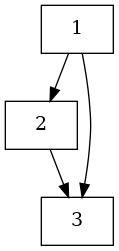

In [24]:
# get the actual result data (Python objects, basically)

print(f"Graph density: {properties_workflow.outputs.density.get_value_data()}")
print(f"Largest component object: {properties_workflow.outputs.largest_component.get_value_data()}")
print(f"Graph density: {properties_workflow.outputs.density.get_value_data()}")


# and we can visualize the largest component
largest_component_graph = properties_workflow.outputs.largest_component.get_value_data()
graph_to_image(largest_component_graph)

Observe that the single, non-connected node '4' is removed now again.

## Finding the shortest path between two nodes

The 2nd network analysis module i've prepared is for finding the shortest path between two nodes.

Again, let's check it out:

In [25]:
module_info = kiara.get_module_info("find_shortest_path")
kiara.explain(module_info)

╭─ Module: find_shortest_path ──────────────────────────────────────────────────────────────╮
│                                                                                           │
│   class          kiara_modules.default.network_analysis.FindShortestPathModule            │
│                                                                                           │
│   is pipeline    no                                                                       │
│                                                                                           │
│   doc            Find the shortest path between two nodes in a graph.                     │
│                                                                                           │
│   source repo    ]8;id=1620380147.754707-222295;https://dharpa.org/kiara_modules.default/api_reference/kiara_modules.default.network_analysis/#kiara_modules.default.network_analysis.FindShortestPathModule\kiara_modules.default.find_shortest_path]8;;\                                 │
│                                                                                           │
│   config class   kiara_modules.default.network_analysis.FindShortestPathModuleConfig      │
│                                                                                           │
│   config          ────────────────────────────────────────────────────────────────────    │
│                    constants   object   Value constants for this module.                  │
│                    mode        string   Whether to calculate one shortest path for        │
│                                         only one pair ('single-pair'), or use two         │
│                                         node lists as input and select one of the         │
│                                         following strategies: shortest path for each      │
│                                         pair ('one-to-one'), the shortest path to all     │
│                                         targets ('one-to-many'), or a matrix of all       │
│                                         possible combinations ('many-to-many').           │
│                   ────────────────────────────────────────────────────────────────────    │
│                                                                                           │
│   src            def process(self, inputs: StepInputs, outputs: StepOutputs) -> None:     │
│                                                                                           │
│                      mode = self.get_config_value("mode")                                 │
│                      if mode != "single-pair":                                            │
│                          raise NotImplementedError()                                      │
│                                                                                           │
│                      graph: Graph = inputs.graph                                          │
│                      source: typing.Any = inputs.source_node                              │
│                      target: typing.Any = inputs.target_node                              │
│                                                                                           │
│                      if source not in graph.nodes:                                        │
│                          raise KiaraProcessingException(                                  │
│                              f"Can't process shortest path, source '{source}' not in g…   │
│                          )                                                                │
│                                                                                           │
│                      if target not in graph.nodes:                                        │
│                          raise KiaraProcessingException(                                  │
│                              f"Can't proc

This module can be configured in different 'modes'. Only 'single-pair' is implemented currently, but in the future it
will also allow to calculate shortest paths between nodes for multiple source/target pairs.

Creating a workflow from it will, as before, tell us what inputs we need to provide:

In [26]:
shortest_path_workflow = kiara.create_workflow("find_shortest_path")
kiara.explain(shortest_path_workflow)

Workflow: find_shortest_path_0
                                                                                             
  root module      pipeline                                                                  
  current status   STALE                                                                     
  inputs                                                                                     
                     Field name    Type            Description          Required   Is set    
                    ──────────────────────────────────────────────────────────────────────   
                     graph         network_graph   The network graph    yes        no        
                     source_node   any             The id of the        yes        no        
                                                   source node.                              
                     target_node   any             The id of the        yes        no        
                                                   target node.                              
                                                                                             
  outputs                                                                                    
                     Field name   Type    Description                   Required   Is set    
                    ──────────────────────────────────────────────────────────────────────   
                     path         array   The shortest path between     yes        no        
                                          two nodes.


Let's set our inputs and check the result. Let's use our largest component from above as the graph input, for fun and giggles:

In [27]:
shortest_path_workflow.inputs.graph = largest_component_graph
shortest_path_workflow.inputs.source_node = 1
shortest_path_workflow.inputs.target_node = 3

# print output details
kiara.explain(shortest_path_workflow.outputs)
kiara.explain(shortest_path_workflow.outputs.path)
print(f"Shortest path: {shortest_path_workflow.outputs.path.get_value_data()}")

╭─ Value-Set: Outputs for pipeline 'find_shortest_path_0' ──────────────────────────────────╮
│                                                                                           │
│   Field name   Type    Description                            Required   Is set           │
│  ───────────────────────────────────────────────────────────────────────────────          │
│   path         array   The shortest path between two nodes.   yes        yes              │
│                                                                                           │
╰───────────────────────────────────────────────────────────────────────────────────────────╯

╭─ Value: step_output:find_shortest_path_0.find_shortest_path.path ─────────────────────────╮
│                                                                                           │
│   id            e4a812d6-c15e-43bb-be27-a74b13263822                                      │
│   type          array                                                                     │
│   desc          The shortest path between two nodes.                                      │
│   is set        yes                                                                       │
│   is constant   no                                                                        │
│   metadata      {                                                                         │
│                   "type": {                                                               │
│                     "python_cls": "list",                                                 │
│                     "length": 2                                                           │
│                   }                                                                       │
│                 }                                                                         │
│                                                                                           │
╰───────────────────────────────────────────────────────────────────────────────────────────╯

Shortest path: [1, 3]


Ok, that's that. For now. Questions, concerns, let me know!